In [3]:
# Import necessary modules
import scanpy as sc
from visium_hd_functions.image_processing import load_image, normalize_image, load_stardist_model, predict_nuclei

# Set up configurations
#dir_base = '/home/sromero/visium_hd_processing/'
dir_base = 'C:\\Users\\selim\\Documents\\vs_code_workingdir\\visium_hd_processing\\'
img_file = dir_base + 'Visium_HD_Mouse_Small_Intestine_tissue_image.btf'

#dir_hd5 = '/home/sromero/visium_hd_processing/Visium_HD_Mouse_Small_Intestine_binned_outputs/binned_outputs/square_002um/'
dir_hd5 = 'C:\\Users\\selim\\Documents\\vs_code_workingdir\\visium_hd_processing\\Visium_HD_Mouse_Small_Intestine_binned_outputs\\binned_outputs\\square_002um\\'
h5_file = dir_hd5 + 'filtered_feature_bc_matrix.h5'

dir_tissue = dir_hd5 + 'spatial\\'
tissue_position_file = dir_tissue+'tissue_positions.parquet'

# Load and process image
print("Loading and processing image...")
img = load_image(img_file)
img = normalize_image(img, min_percentile = 5, max_percentile = 95)


Loading and processing image...


In [4]:
print("Loading pre-trained StarDist model...")
# Try to download and read from default directory, if fails, use pre-trained model in repository
model_dir = 'default'
#model_dir = 'C:\\Users\\ssromerogon\\Documents\\vscode_working_dir\\visium_hd_processing\\pretrained\\2D_versatile_he\\'
model = load_stardist_model(model_dir)

Loading pre-trained StarDist model...
Trying to load pre-trained model from the default source...
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Pre-trained model loaded from default location.


In [ ]:
print("Predicting nuclei...") # This is crucial (takes time)
labels, polys = predict_nuclei(model, img, block_size = 4096, prob_thresh = 0.01, nms_thresh = 0.001)

Predicting nuclei...
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 42/42 [11:31<00:00, 16.47s/it]


In [ ]:
from visium_hd_functions.data_processing import create_geodataframe, create_geodf_coords, merge_tissue_positions, filter_spatial_overlap, sum_gene_counts_binned

# Create GeoDataFrame using Polygon geometries
print("Creating GeoDataFrame...")
gdf = create_geodataframe(polys['coord'])
# Display summary of the GeoDataFrame
gdf.head()

Creating GeoDataFrame...


,geometry,id
0,"POLYGON ((2240.694 1130, 2240.044 1131.202, 22...",ID_1
1,"POLYGON ((3917.366 710, 3917.391 710.675, 3917...",ID_2
2,"POLYGON ((3922.437 3616, 3921.839 3617.957, 39...",ID_3
3,"POLYGON ((6652.58 2864, 6651.806 2865.951, 665...",ID_4
4,"POLYGON ((6457.917 3596, 6457.598 3597.511, 64...",ID_5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6418919..1.081081].


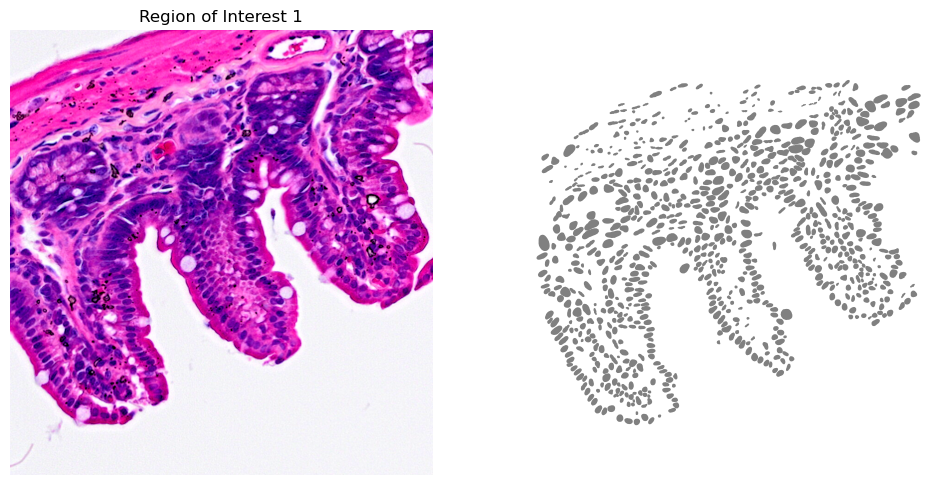

In [ ]:
from visium_hd_functions.plotting import plot_mask_and_save_image, plot_gene_and_save_image, plot_clusters_and_save_image
from matplotlib.colors import ListedColormap

# Plot the nuclei segmentation (ROI)
# bbox=(x min,y min,x max,y max)
bbox=(12844,7700,13760,8664)

# Define a single color cmap
cmap=ListedColormap(['grey'])

# Create Plot
plot_mask_and_save_image(title = "Region of Interest 1", gdf = gdf, bbox = bbox,
                         cmap = cmap,img = img, output_name = dir_base+"image_mask.ROI1.tif")

In [9]:
from visium_hd_functions.clustering import calculate_qc_metrics, filter_and_normalize, perform_clustering

In [10]:
# Process AnnData from Visium HD data
print("Reading AnnData...")
print(h5_file)
adata = sc.read_10x_h5(h5_file)

# Display summary of AnnData object
adata

Reading AnnData...
C:\Users\selim\Documents\vs_code_workingdir\visium_hd_processing\Visium_HD_Mouse_Small_Intestine_binned_outputs\binned_outputs\square_002um\filtered_feature_bc_matrix.h5


anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5479660 × 19059
    var: 'gene_ids', 'feature_types', 'genome'

In [12]:
# Load the Spatial Coordinates
dir_tissue = dir_hd5 + 'spatial/'
tissue_position_file = dir_tissue+'tissue_positions.parquet'

# Adding tissue positions to the meta data + df with tissue positions and barcodes
print("Merging tissue positions...")
adata, df_tissue_positions = merge_tissue_positions(adata, tissue_position_file)

Merging tissue positions...


In [19]:
# Create a GeoDataFrame from the DataFrame of coordinates 
gdf_coordinates = create_geodf_coords(df_tissue_positions)

In [20]:
# Spatial join check of coordinates that are in a cell nucleus
filtered_adata = filter_spatial_overlap(adata, gdf, gdf_coordinates)

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
# Filter data by binned data - sc matrix overlap (takes time)
grouped_filtered_adata = sum_gene_counts_binned(filtered_adata)

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [22]:
# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area

# Perform quality control and normalization
print("Calculating QC metrics...")
calculate_qc_metrics(grouped_filtered_adata)


Calculating QC metrics...


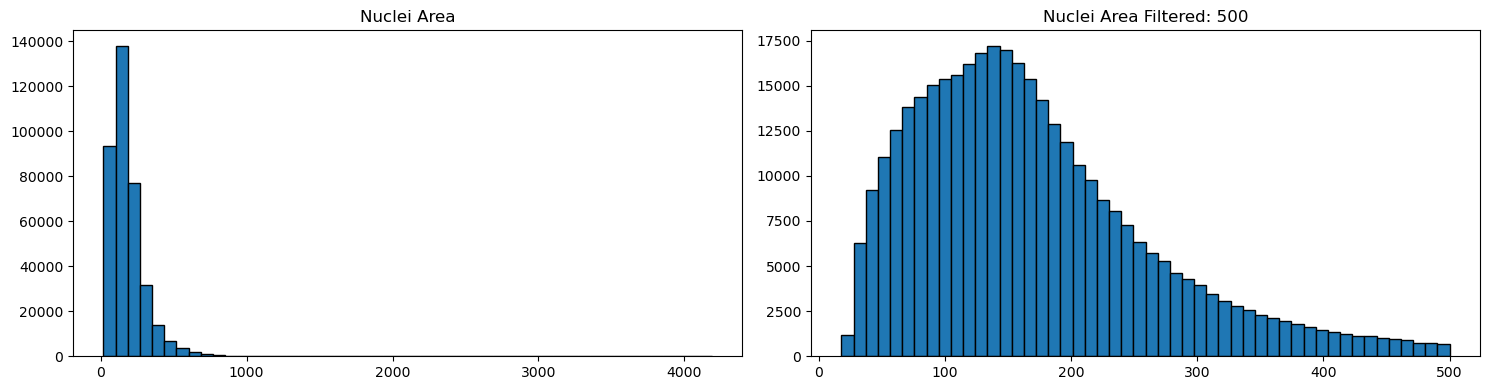

In [23]:
# Plot the nuclei area distribution before and after filtering
from visium_hd_functions.plotting import plot_nuclei_area

plot_nuclei_area(gdf=gdf,area_cut_off=500)

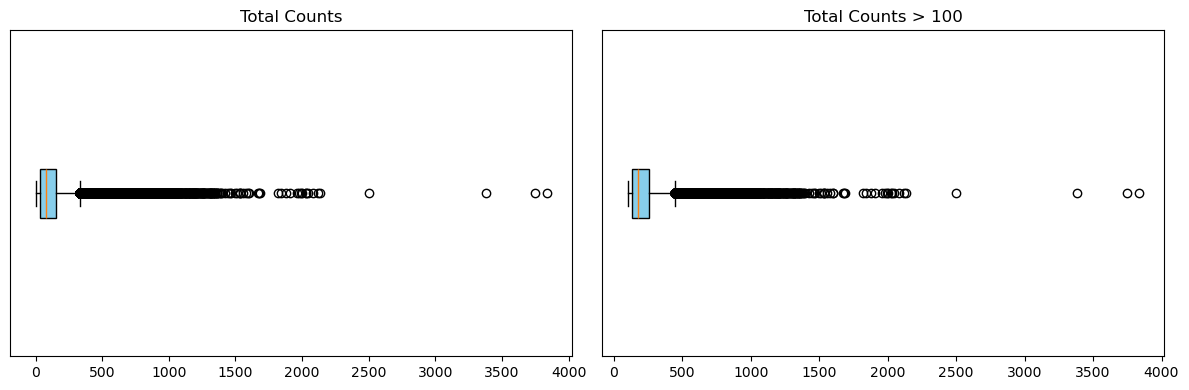

In [24]:
# Plot total UMI distribution
from plotting import total_umi

total_umi(grouped_filtered_adata, 100)

In [25]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata.obs['id'].isin(gdf[gdf['area'] < 500].id)
# Create a mask based on the 'total_counts' column for values greater than 100
mask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
grouped_filtered_adata = filter_and_normalize(grouped_filtered_adata, mask_area, mask_count)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [26]:
# Perform clustering
print("Performing clustering...")
grouped_filtered_adata = perform_clustering(grouped_filtered_adata)


Performing clustering...


clustering.py (17): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6418919..1.081081].


Plotting segmentation...


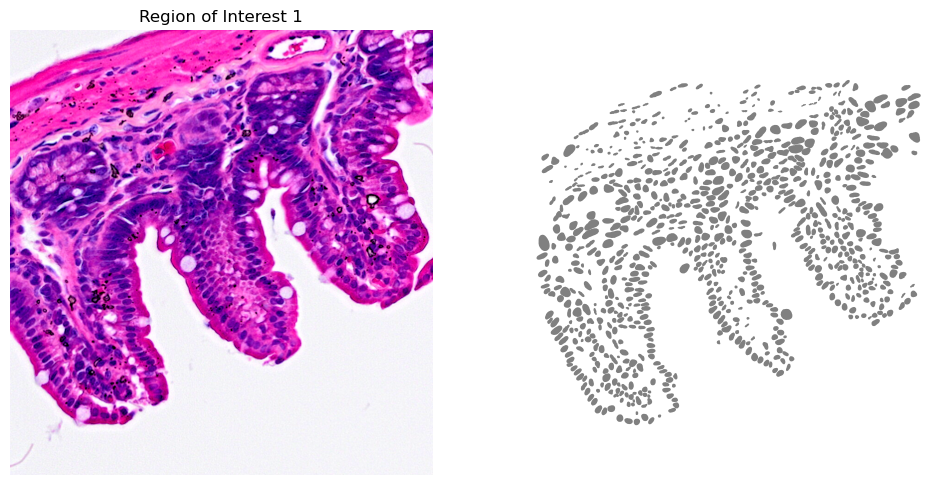

In [27]:
# Plot results
from plotting import plot_gene_and_save_image, plot_clusters_and_save_image, plot_mask_and_save_image

# Plot the nuclei segmentation (ROI)
# bbox=(x min,y min,x max,y max)
bbox=(12844,7700,13760,8664)

# Define a single color cmap
cmap=ListedColormap(['grey'])

print("Plotting segmentation...")
plot_mask_and_save_image(title = "Region of Interest 1", gdf = gdf, bbox = bbox,cmap = cmap,img = img, output_name = dir_base+"image_mask.ROI1.tif")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6418919..1.081081].


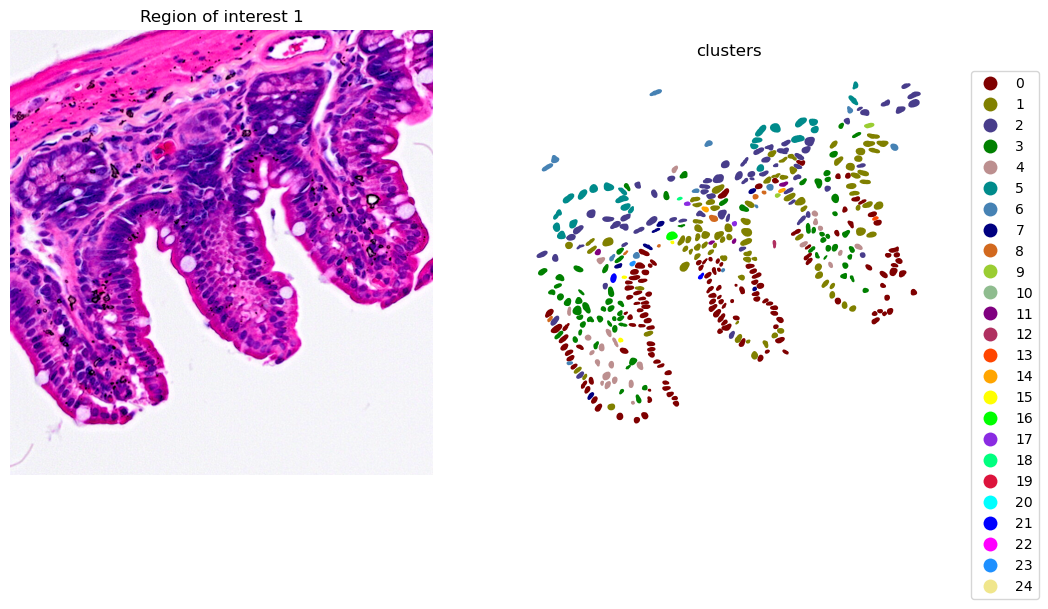

In [28]:
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=grouped_filtered_adata, bbox=bbox, color_by_obs='clusters', output_name=dir_base+"image_clustering.ROI1.tiff")

Plotting gene expression...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6418919..1.081081].


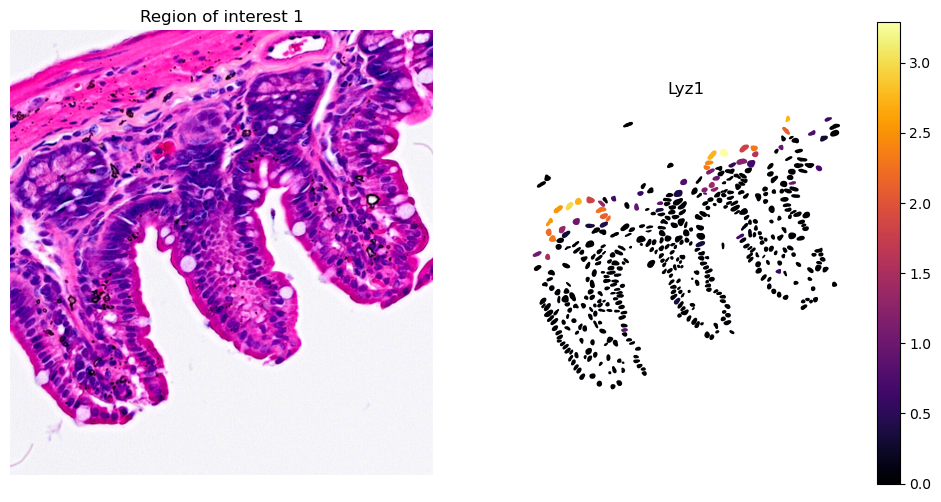

In [29]:

print("Plotting gene expression...")
# Plot Lyz1 gene expression
plot_gene_and_save_image(title="Region of interest 1", gdf=gdf, gene='Lyz1', img=img, adata=grouped_filtered_adata, bbox= bbox,output_name=dir_base+"image_Lyz1.ROI1.tiff")


In [ ]:
# Save results
print("Saving processed data...")
adata.write_h5ad(dir_base + 'processed_data.h5ad')
print("Pipeline complete!")
